# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 24

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 514
Num noneffect sequences: 	 514
Num scores: 	 	 	 514


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.38410593971084367
Median KS-test p-value: 	 0.31442634514242196
St. Dev KS-test p-value: 	 0.3146931352260832
Max KS-test p-value: 	 	 0.9956362903809558
Min KS-test p-value: 	 	 3.5065668559889515e-14
Num significant p-values: 	 52

Mean non-zero motif length: 	 9.017777777777777
Median non-zero motif length: 	 9
St. Dev non-zero motif length: 	 6.191846917840286
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.809338521400779
Median motif length: 	 	 10.0
St. Dev motif length: 	 	 2.643656269255744
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 443


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 443


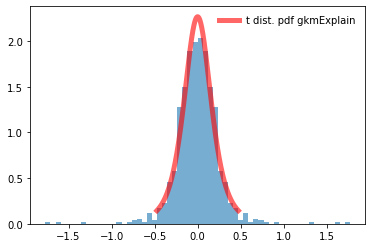

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 3.6739792067842236
Mean: 	 1.6957613191873975e-07
Stdev: 	 0.16457726989333613

KstestResult(statistic=0.016465948502848993, pvalue=0.969913938618348)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 193


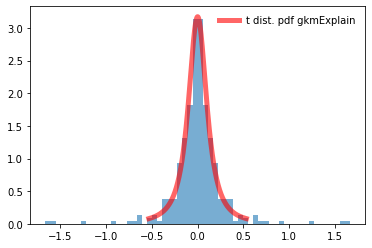

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 1.7851303867620325
Mean: 	 -7.203508762144737e-07
Stdev: 	 0.10993451967970683

KstestResult(statistic=0.029026269751506906, pvalue=0.9010287001571695)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 193


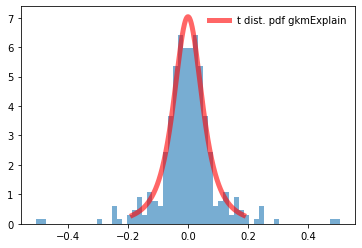

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 2.4638088104101934
Mean: 	 -2.725985403465733e-07
Stdev: 	 0.051365824149342446

KstestResult(statistic=0.023913717631870002, pvalue=0.9800515103797502)


## Distribution of ISM Scores

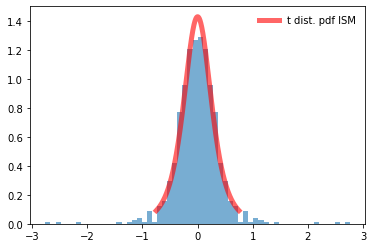

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 3.6905383605841218
Mean: 	 4.731319655696807e-07
Stdev: 	 0.2614177492881273

KstestResult(statistic=0.01396430760673234, pvalue=0.9952223699770346)


## Distribution of Delta Scores

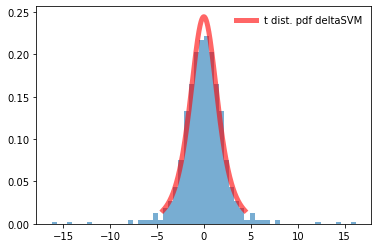

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 3.7311566821918847
Mean: 	 -2.091737737614436e-06
Stdev: 	 1.5270592011574307

KstestResult(statistic=0.014633469234988095, pvalue=0.9913698390249271)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.47338378853476404
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.5319875502737322
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.08931569033741613
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.1855595248302858
Negative ISM Cutoff: 	 	 	 	 	 -0.7504557915951531
Negative deltaSVM Cutoff: 	 	 	 	 -4.363039149326195

Total SNPs with Negative Scores: 	 	 	 10
Confident SNPs with Negative Scores: 	 	 	 6
Highly Confident SNPs with Negative Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
511,chr8,27369272,27369273,rs755951,A,C,A,"C,T",A,"C,T",-,126,0.015888,0.760496,0.094723,0.574067,-0.755764,-0.702209,-0.479344,-1.180383,-6.781863,Alzheimers_Jansen_2018,1.307576e-11,True,True,TGGCCTGTAGGGGG,TGGCATGTAGGGGG,0.012306,0.031084,0.005548,0.012861,0.013238,6.909053e-01,2
358,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.185569,0.842432,0.114495,0.365613,-0.688913,-0.656862,-0.251117,-1.074125,-6.081059,Alzheimers_Jansen_2018,9.125833e-17,False,True,GCCCCGCCCAAT,GCCCTGCCCAAT,0.016527,0.034880,0.025503,0.017362,0.018746,6.092832e-01,2
402,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.298397,0.783112,0.141335,0.295763,-0.577945,-0.484714,-0.154427,-0.910455,-5.260240,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGT,GAGGGTGCTGT,0.028293,0.058477,0.073586,0.028788,0.029232,7.487745e-01,1
148,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.395962,1.152643,0.106300,0.258984,-0.757415,-0.756681,-0.152684,-1.182093,-7.002519,Alzheimers_Lambert_2013,4.789000e-05,True,True,TGGCCCCGCCCC,TGGCCTCGCCCC,0.012220,0.027307,0.075314,0.012801,0.011930,5.589637e-05,1
445,chr4,89829438,89829439,rs2737005,G,A,A,G,A,G,+,103,0.791359,1.417258,0.477211,0.619697,-0.632864,-0.625899,-0.142486,-0.995665,-5.691319,23andme_PD_hg38,1.087510e-08,True,True,GCAACACTTCCTCT,GCAACGCTTCCTCT,0.021511,0.037899,0.086575,0.021971,0.023027,7.581954e-02,1
119,chr14,92466230,92466231,rs10130373,C,A,C,"A,G,T",A,"C,G,T",+,39,1.417110,2.309335,0.430382,0.550012,-0.906783,-0.892224,-0.119631,-1.411342,-8.067634,Alzheimers_Jansen_2018,6.157006e-09,False,True,GCAAGAGGAAGTTA,GCAAGCGGAAGTTA,0.006763,0.020486,0.121176,0.007148,0.007459,4.301766e-01,1
240,chr19,18462023,18462024,rs8103622,T,C,C,T,C,T,+,69,1.351541,1.851129,0.565316,0.641697,-0.492861,-0.499588,-0.076382,-0.810207,-4.615416,Alzheimers_Kunkle_2019,1.279000e-05,True,False,AGAGCGCCACCTGCTG,AGAGTGCCACCTGCTG,0.044745,0.055587,0.252397,0.040396,0.042749,7.989503e-01,0
425,chr3,151399027,151399028,rs4680406,G,A,G,A,G,A,+,87,2.528459,2.918305,0.492948,0.513212,-0.557873,-0.389847,-0.020264,-0.886288,-5.124448,Nalls_23andMe,2.140370e-05,False,True,GGAAGTGAAACCACA,GGAAGTGAAACCGCA,0.031404,0.083736,0.724814,0.031172,0.031593,7.748229e-07,0
54,chr11,60332877,60332878,rs2868118,T,C,C,T,C,T,+,11,-0.062165,0.020280,0.000000,0.019150,-0.648575,-0.020280,-0.019150,-1.018335,-5.849728,Alzheimers_Jansen_2018,1.596942e-08,False,True,CACCCGCATG,CACCTGCATG,0.019947,0.872440,0.738985,0.020500,0.021157,7.828899e-01,0
418,chr3,122416407,122416408,rs55911744,T,G,T,G,T,G,-,86,-0.040966,0.027335,0.000000,0.013523,-0.538743,-0.027335,-0.013523,-0.846064,-4.891249,Nalls_23andMe,4.986370e-04,False,True,CACCGGACGC,CACCTGACGC,0.034762,0.829275,0.812784,0.035690,0.036207,9.960754e-02,0



Positive Original gkmExplain Cutoff: 	 	 	 0.4733841276870277
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.5319861095719796
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.08931514514033544
Positive Ratio Difference gkmExplain High Cutoff: 	 0.185558979633205
Positive ISM Cutoff: 	 	 	 	 	 0.7504567378590842
Positive deltaSVM Cutoff: 	 	 	 	 4.363034965850719

Total SNPs with Positive Scores: 	 	 	 9
Confident SNPs with Positive Scores: 	 	 	 7
Highly Confident SNPs with Positive Scores: 	 	 5


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
503,chr8,16837908,16837909,rs1717289,T,C,C,T,C,T,-,124,1.291452,0.006272,0.561228,0.053513,1.355042,1.236623,0.507715,2.126081,12.197856,Chang_23andMe_Parkinsons,2.216050e-04,False,False,TTTCAGTTCCT,TTTCAGCTCCT,0.001697,0.011536,0.004829,0.001740,0.001774,0.085762,2
237,chr19,18438073,18438074,rs2303696,C,T,T,C,C,T,+,69,0.744757,0.090879,0.377682,0.085718,0.656209,0.629876,0.291964,1.054062,5.960297,Alzheimers_Kunkle_2019,1.893000e-05,True,True,GTCCCCGCCCCGAA,GTCCCTGCCCCGAA,0.019238,0.037489,0.018014,0.018418,0.019960,0.158939,2
38,chr11,60251676,60251677,rs636317,C,T,C,T,T,C,-,11,2.428278,0.824993,0.708929,0.457696,1.623125,1.603285,0.251233,2.524755,14.534439,Alzheimers_Kunkle_2019,5.906000e-15,False,True,TGCTGCCATCTGCTGGGAAAT,TGCTGCTATCTGCTGGGAAAT,0.000895,0.007283,0.025476,0.000945,0.000946,0.017029,2
415,chr3,52498433,52498434,rs181391313,G,A,G,A,G,A,-,93,0.353120,-0.031347,0.262038,0.015365,0.536489,0.338137,0.246673,0.839080,4.842568,Chang_23andMe_Parkinsons,2.730650e-03,False,True,GGGCGGAG,GGGCAGAG,0.035185,0.105107,0.026564,0.036553,0.037269,0.684936,2
390,chr2,134782975,134782976,rs7599054,G,A,A,"G,T",G,"A,T",-,78,2.644186,0.978424,0.647708,0.413091,1.768270,1.660370,0.234618,2.760683,16.211443,Chang_23andMe_Parkinsons,1.579610e-06,False,True,CCACTAGGGGGCA,CCACTAGGGGACA,0.000659,0.006845,0.029762,0.000686,0.000637,0.055935,2
205,chr17,58332679,58332680,rs2526377,A,G,A,G,A,G,+,57,1.060745,0.568414,0.407168,0.280452,0.549806,0.480614,0.126715,0.914804,5.363258,Alzheimers_Jansen_2018,9.126944e-07,True,True,ACAGGAAACAGAAGGG,ACAGGAAACAGAGGGG,0.032770,0.059314,0.108778,0.028383,0.027582,0.241535,1
2,chr1,39890482,39890483,rs6684490,A,G,A,G,A,G,-,31,2.509527,1.959020,0.620773,0.562912,0.562895,0.550506,0.057862,0.881562,5.153233,Alzheimers_Kunkle_2019,1.540000e-05,True,True,ACTTCCCTATTTCAAAGAGGATGT,ACTTCCCTGTTTCAAAGAGGATGT,0.030589,0.047183,0.357647,0.031665,0.031074,0.046850,1
509,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.053960,-0.049076,0.034254,0.000000,0.782766,0.053960,0.034254,1.240627,7.958513,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,CCCCCGCCGC,0.010985,0.677173,0.561910,0.010945,0.007808,0.442843,0
306,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.000000,0.000000,0.000000,0.000000,0.529016,0.000000,0.000000,0.884791,5.108621,Alzheimers_Kunkle_2019,2.690000e-238,True,True,GGGTAGGGGG,GGGTGGGGGG,0.036634,0.999995,0.999996,0.031327,0.031883,0.486334,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 511

RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 126   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.3076E-11   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.7605   ||   Center / 200bp : 0.5741

Noneffect Motif: TGGCCTGTAGGGGG


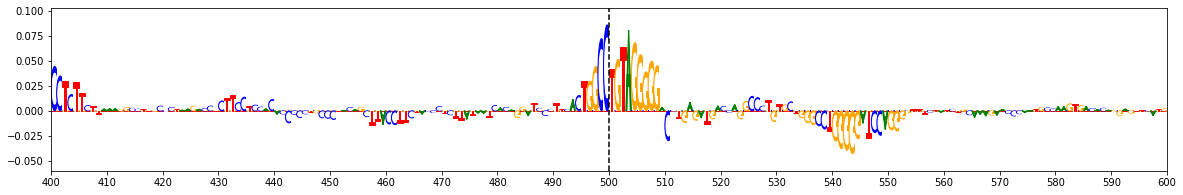

Effect Allele: A   ||   Effect Center: 0.0159   ||   Center / 200bp : 0.0947

Effect Motif: TGGCATGTAGGGGG


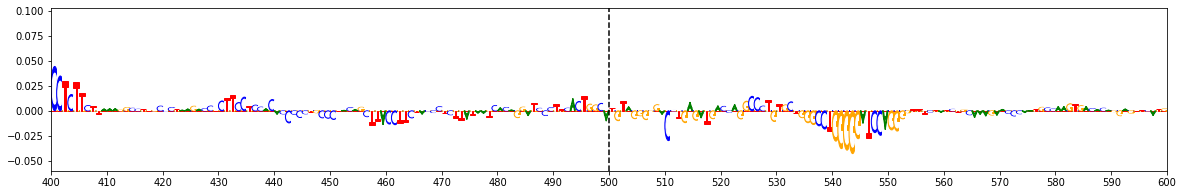

gkmExplain Score: -0.4793  ||  ISM Score: -1.1804  ||  deltaSVM Score: -6.7819

gkmExplain P-Value: 0.005548  ||  ISM P-Value: 0.012861  ||  deltaSVM P-Value: 0.013238

Difference Motif: TGGC(C/A)TGTAGGGGG


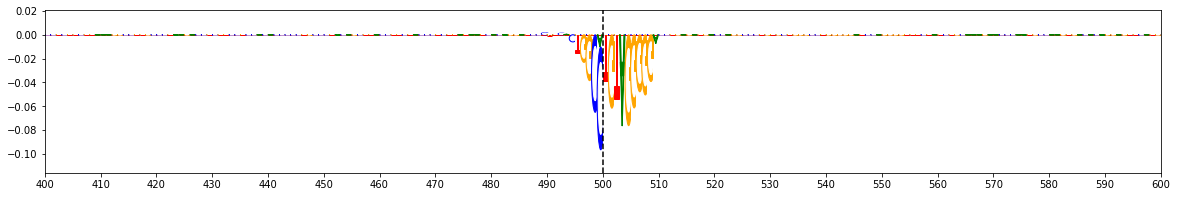



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 358

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 77   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1258E-17   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.8424   ||   Center / 200bp : 0.3656

Noneffect Motif: GCCCCGCCCAAT


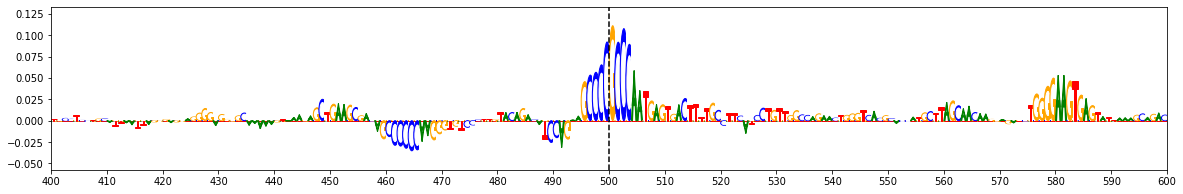

Effect Allele: T   ||   Effect Center: 0.1856   ||   Center / 200bp : 0.1145

Effect Motif: GCCCTGCCCAAT


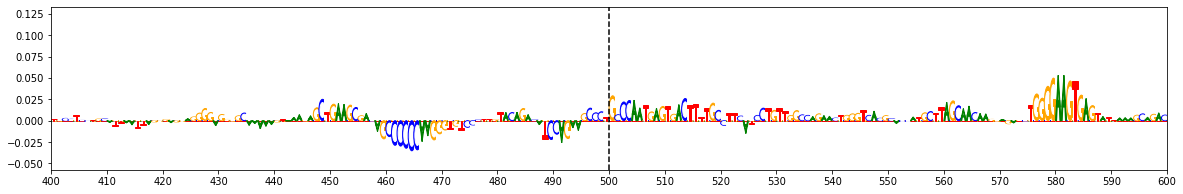

gkmExplain Score: -0.2511  ||  ISM Score: -1.0741  ||  deltaSVM Score: -6.0811

gkmExplain P-Value: 0.025503  ||  ISM P-Value: 0.017362  ||  deltaSVM P-Value: 0.018746

Difference Motif: GCCC(C/T)GCCCAAT


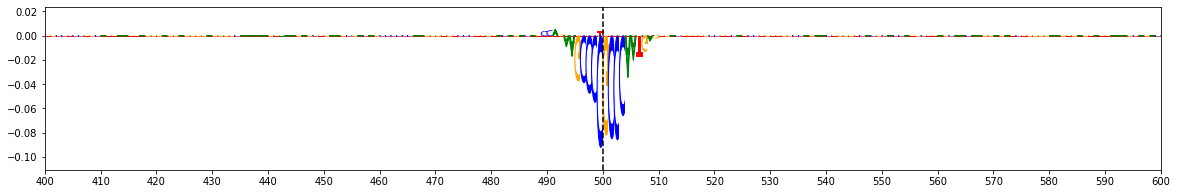



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 402

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.7831   ||   Center / 200bp : 0.2958

Noneffect Motif: GAGGGCGCTGT


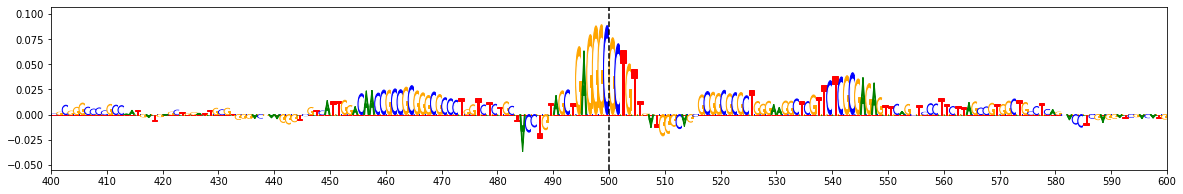

Effect Allele: T   ||   Effect Center: 0.2984   ||   Center / 200bp : 0.1413

Effect Motif: GAGGGTGCTGT


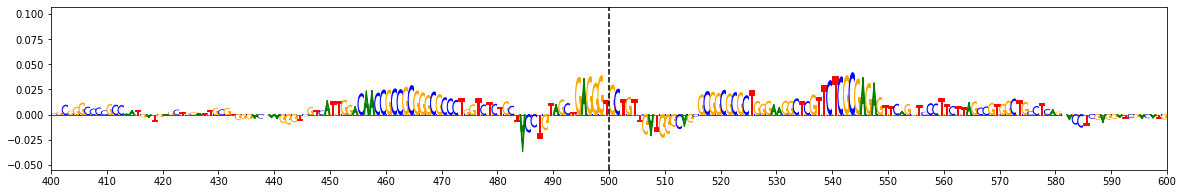

gkmExplain Score: -0.1544  ||  ISM Score: -0.9105  ||  deltaSVM Score: -5.2602

gkmExplain P-Value: 0.073586  ||  ISM P-Value: 0.028788  ||  deltaSVM P-Value: 0.029232

Difference Motif: GAGGG(C/T)GCTGT


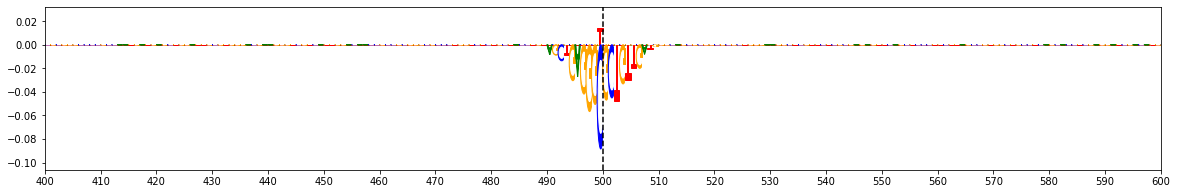



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 148

RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 55   ||    IDR Peak: True

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.7890E-05   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 1.1526   ||   Center / 200bp : 0.259

Noneffect Motif: TGGCCCCGCCCC


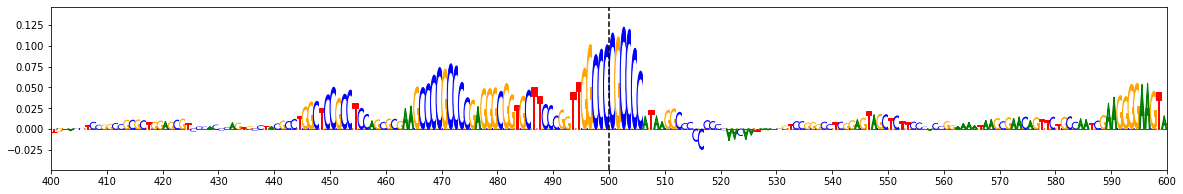

Effect Allele: T   ||   Effect Center: 0.396   ||   Center / 200bp : 0.1063

Effect Motif: TGGCCTCGCCCC


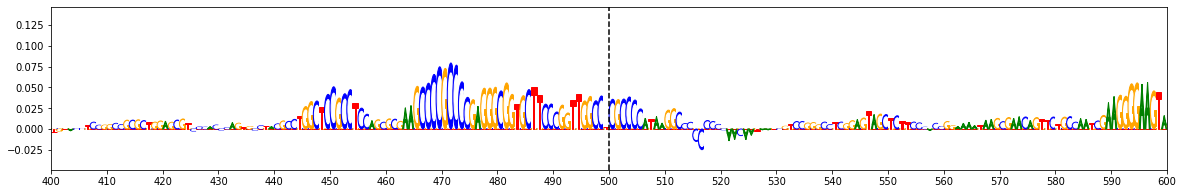

gkmExplain Score: -0.1527  ||  ISM Score: -1.1821  ||  deltaSVM Score: -7.0025

gkmExplain P-Value: 0.075314  ||  ISM P-Value: 0.012801  ||  deltaSVM P-Value: 0.01193

Difference Motif: TGGCC(C/T)CGCCCC


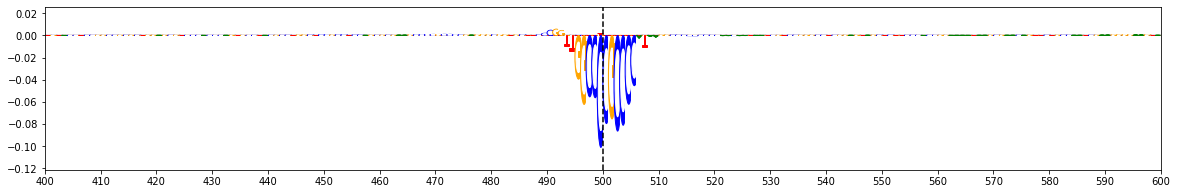



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 445

RSID: rs2737005   ||    chr4 : 89829438 - 89829439   ||    Locus: 103   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.0875E-08   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 1.4173   ||   Center / 200bp : 0.6197

Noneffect Motif: GCAACACTTCCTCT


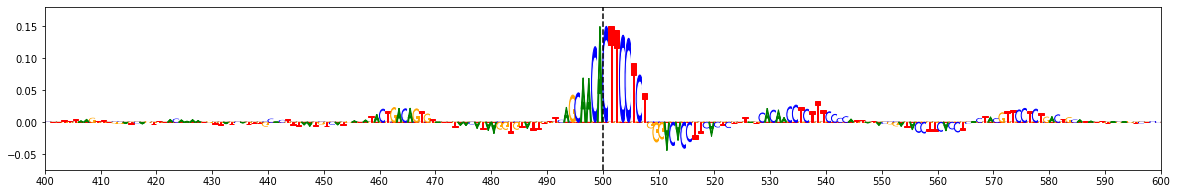

Effect Allele: G   ||   Effect Center: 0.7914   ||   Center / 200bp : 0.4772

Effect Motif: GCAACGCTTCCTCT


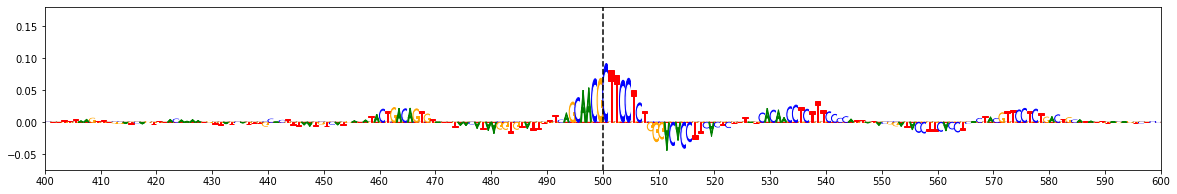

gkmExplain Score: -0.1425  ||  ISM Score: -0.9957  ||  deltaSVM Score: -5.6913

gkmExplain P-Value: 0.086575  ||  ISM P-Value: 0.021971  ||  deltaSVM P-Value: 0.023027

Difference Motif: GCAAC(A/G)CTTCCTCT


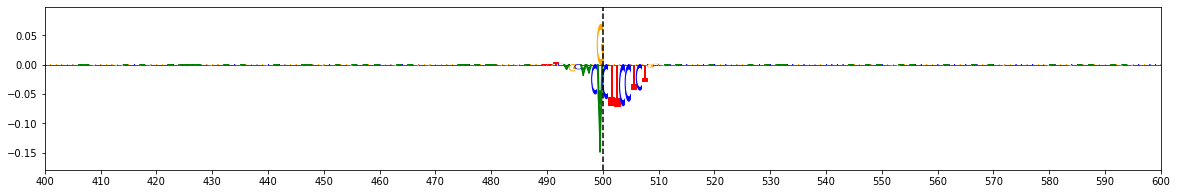



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 119

RSID: rs10130373   ||    chr14 : 92466230 - 92466231   ||    Locus: 39   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 6.1570E-09   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 2.3093   ||   Center / 200bp : 0.55

Noneffect Motif: GCAAGAGGAAGTTA


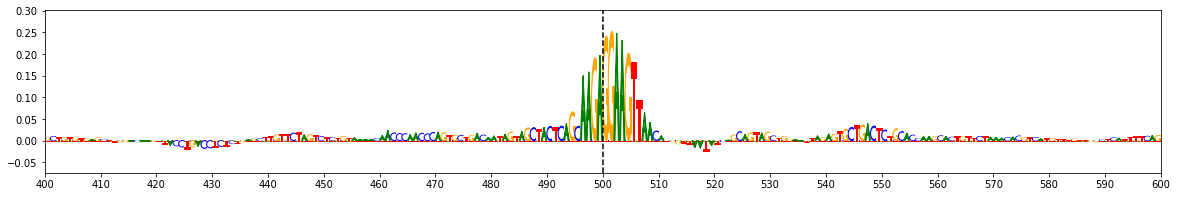

Effect Allele: C   ||   Effect Center: 1.4171   ||   Center / 200bp : 0.4304

Effect Motif: GCAAGCGGAAGTTA


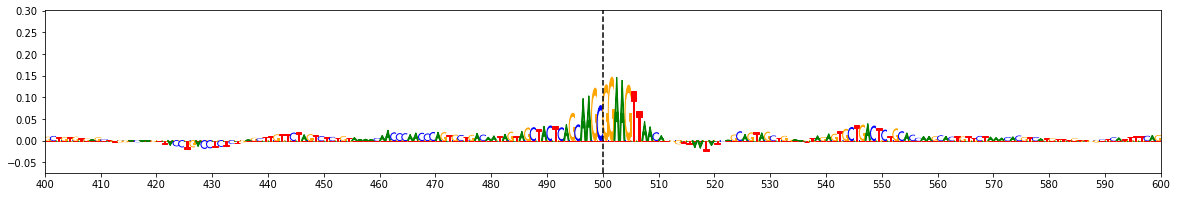

gkmExplain Score: -0.1196  ||  ISM Score: -1.4113  ||  deltaSVM Score: -8.0676

gkmExplain P-Value: 0.121176  ||  ISM P-Value: 0.007148  ||  deltaSVM P-Value: 0.007459

Difference Motif: GCAAG(A/C)GGAAGTTA


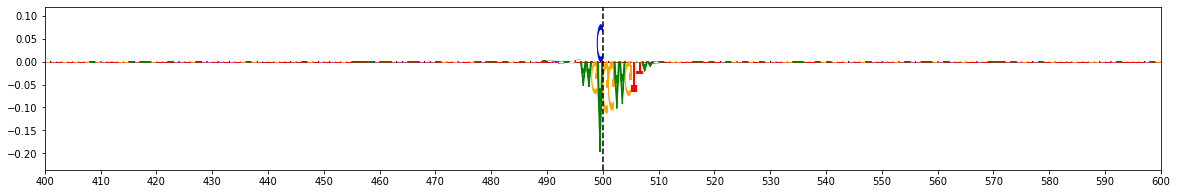



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 240

RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 69   ||    IDR Peak: False

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.2790E-05   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 1.8511   ||   Center / 200bp : 0.6417

Noneffect Motif: AGAGCGCCACCTGCTG


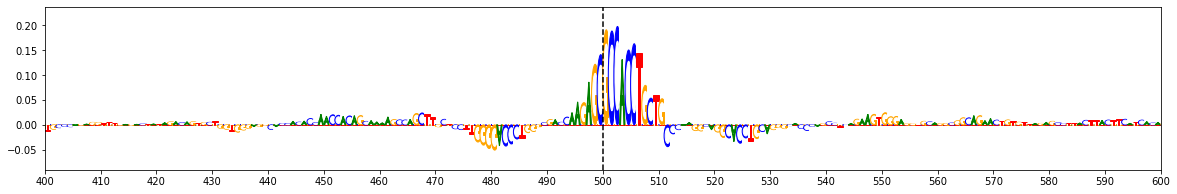

Effect Allele: T   ||   Effect Center: 1.3515   ||   Center / 200bp : 0.5653

Effect Motif: AGAGTGCCACCTGCTG


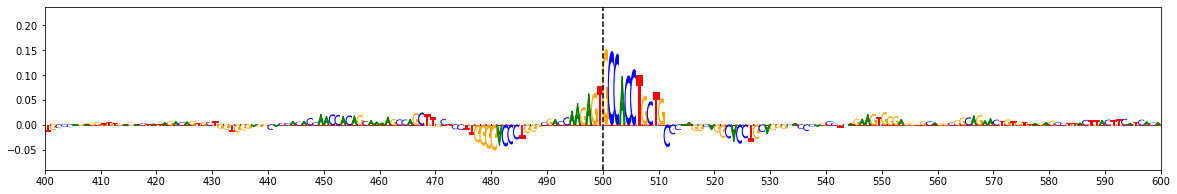

gkmExplain Score: -0.0764  ||  ISM Score: -0.8102  ||  deltaSVM Score: -4.6154

gkmExplain P-Value: 0.252397  ||  ISM P-Value: 0.040396  ||  deltaSVM P-Value: 0.042749

Difference Motif: AGAG(C/T)GCCACCTGCTG


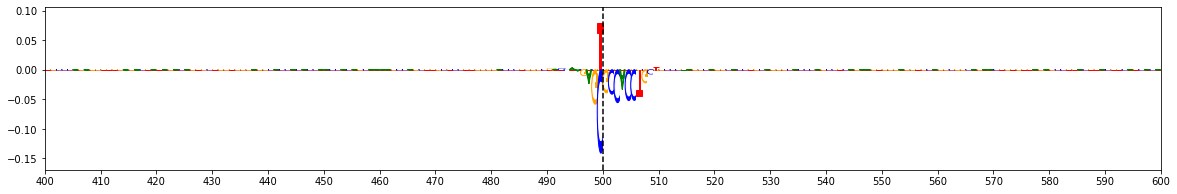



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 425

RSID: rs4680406   ||    chr3 : 151399027 - 151399028   ||    Locus: 87   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 2.1404E-05   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 2.9183   ||   Center / 200bp : 0.5132

Noneffect Motif: GGAAGTGAAACCACA


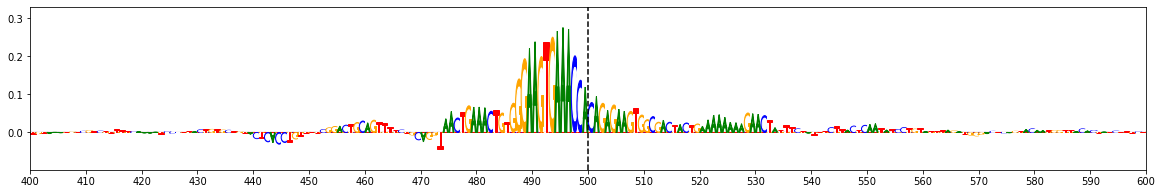

Effect Allele: G   ||   Effect Center: 2.5285   ||   Center / 200bp : 0.4929

Effect Motif: GGAAGTGAAACCGCA


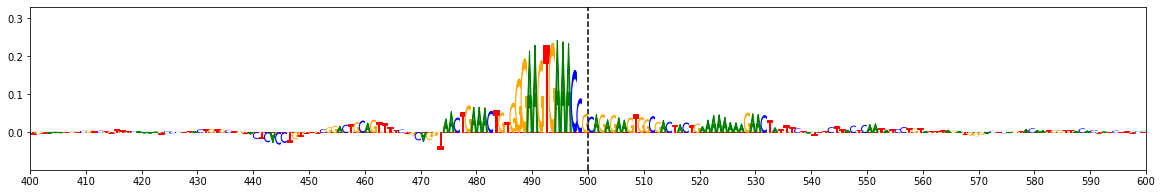

gkmExplain Score: -0.0203  ||  ISM Score: -0.8863  ||  deltaSVM Score: -5.1244

gkmExplain P-Value: 0.724814  ||  ISM P-Value: 0.031172  ||  deltaSVM P-Value: 0.031593

Difference Motif: GGAAGTGAAACC(A/G)CA


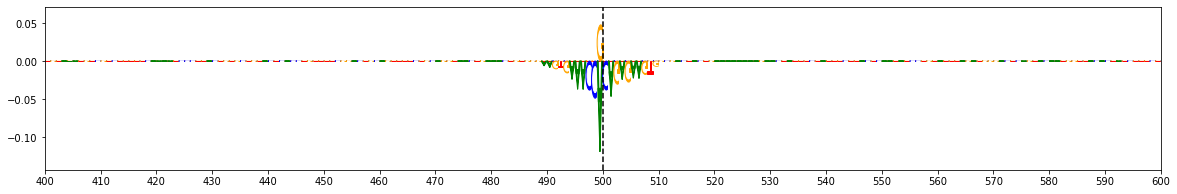



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 54

RSID: rs2868118   ||    chr11 : 60332877 - 60332878   ||    Locus: 11   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.5969E-08   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0203   ||   Center / 200bp : 0.0192

Noneffect Motif: CACCCGCATG


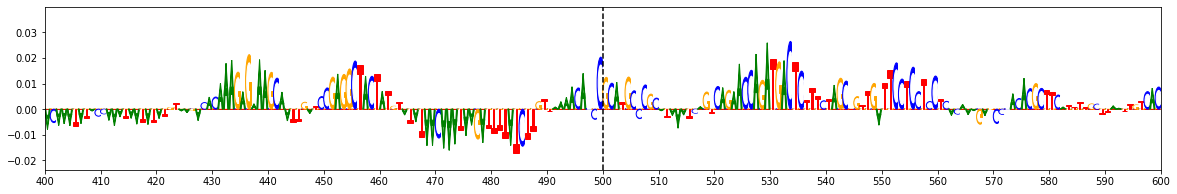

Effect Allele: T   ||   Effect Center: -0.0622   ||   Center / 200bp : 0.0

Effect Motif: CACCTGCATG


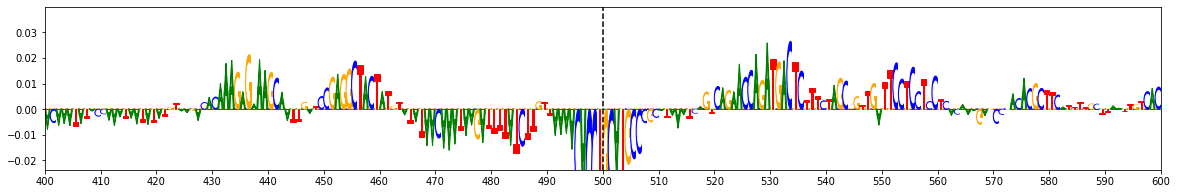

gkmExplain Score: -0.0192  ||  ISM Score: -1.0183  ||  deltaSVM Score: -5.8497

gkmExplain P-Value: 0.738985  ||  ISM P-Value: 0.0205  ||  deltaSVM P-Value: 0.021157

Difference Motif: CACC(C/T)GCATG


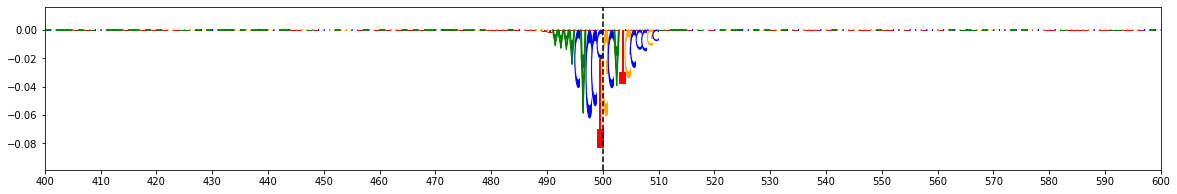



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 418

RSID: rs55911744   ||    chr3 : 122416407 - 122416408   ||    Locus: 86   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.9864E-04   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0273   ||   Center / 200bp : 0.0135

Noneffect Motif: CACCGGACGC


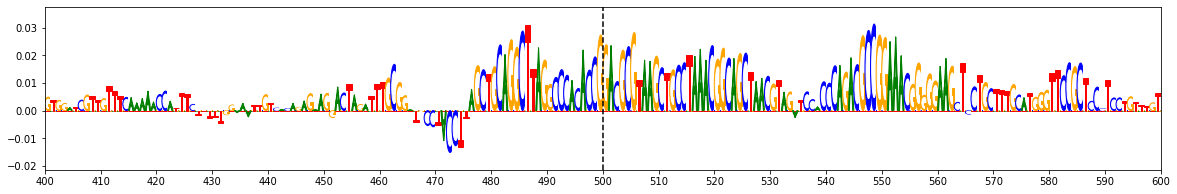

Effect Allele: T   ||   Effect Center: -0.041   ||   Center / 200bp : 0.0

Effect Motif: CACCTGACGC


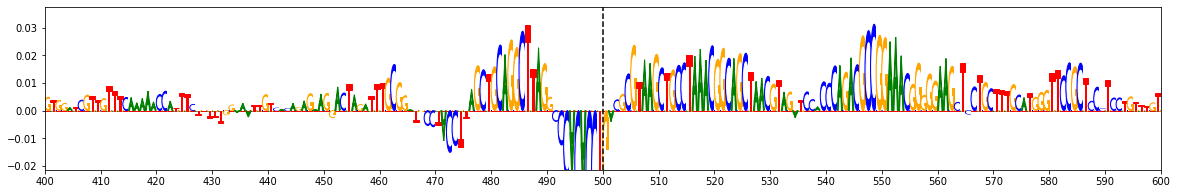

gkmExplain Score: -0.0135  ||  ISM Score: -0.8461  ||  deltaSVM Score: -4.8912

gkmExplain P-Value: 0.812784  ||  ISM P-Value: 0.03569  ||  deltaSVM P-Value: 0.036207

Difference Motif: CACC(G/T)GACGC


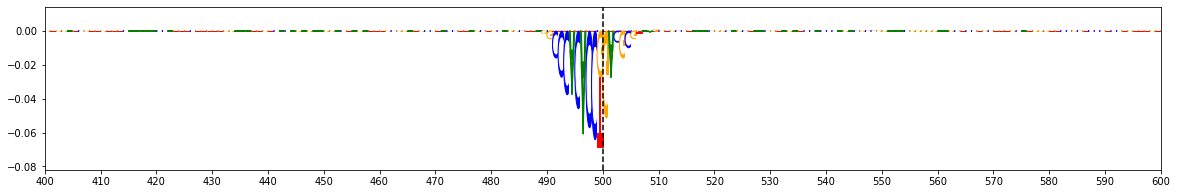



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 503

RSID: rs1717289   ||    chr8 : 16837908 - 16837909   ||    Locus: 124   ||    IDR Peak: False

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.2160E-04   ||    Coloc: False   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 1.2915   ||   Center / 200bp : 0.5612

Effect Motif: TTTCAGTTCCT


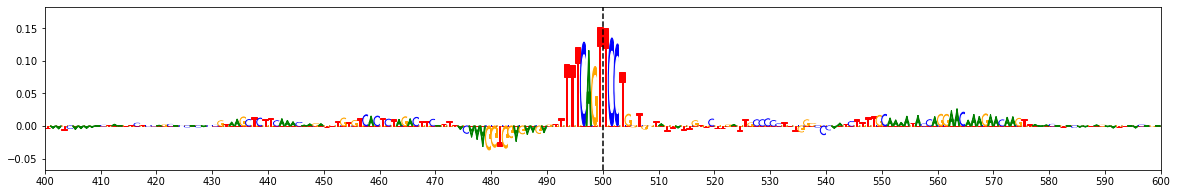

Noneffect Allele: C   ||   Noneffect Center: 0.0063   ||   Center / 200bp : 0.0535

Noneffect Motif: TTTCAGCTCCT


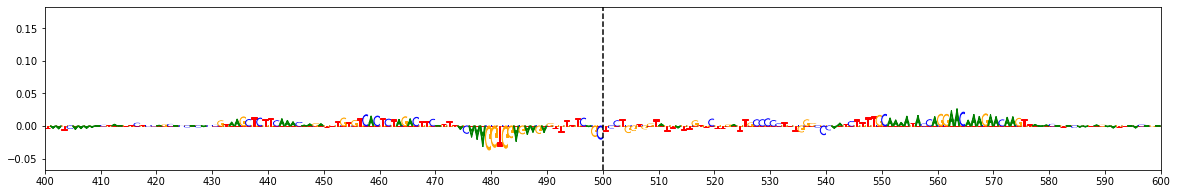

gkmExplain Score: 0.5077  ||  ISM Score: 2.1261  ||  deltaSVM Score: 12.1979

gkmExplain P-Value: 0.004829  ||  ISM P-Value: 0.00174  ||  deltaSVM P-Value: 0.001774

Difference Motif: TTTCAG(T/C)TCCT


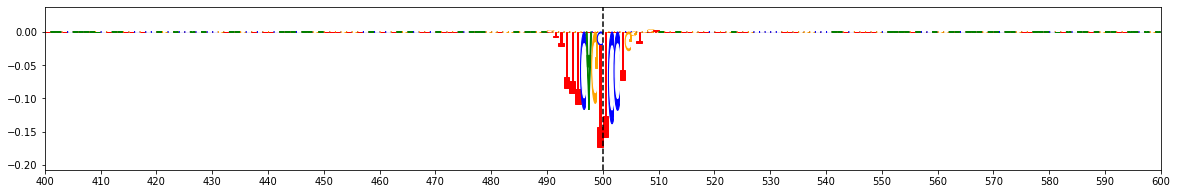



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 237

RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 69   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.8930E-05   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.7448   ||   Center / 200bp : 0.3777

Effect Motif: GTCCCCGCCCCGAA


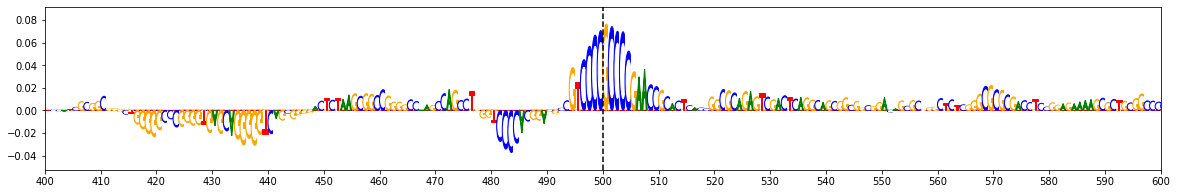

Noneffect Allele: T   ||   Noneffect Center: 0.0909   ||   Center / 200bp : 0.0857

Noneffect Motif: GTCCCTGCCCCGAA


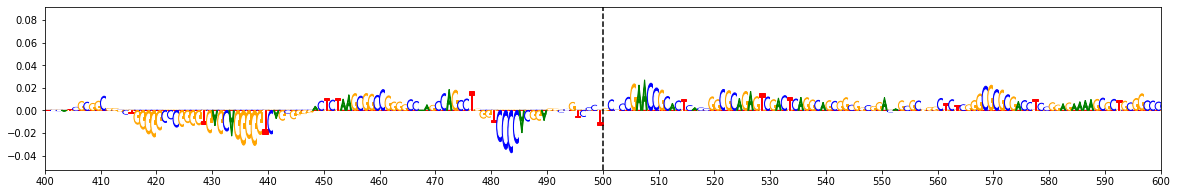

gkmExplain Score: 0.292  ||  ISM Score: 1.0541  ||  deltaSVM Score: 5.9603

gkmExplain P-Value: 0.018014  ||  ISM P-Value: 0.018418  ||  deltaSVM P-Value: 0.01996

Difference Motif: GTCCC(C/T)GCCCCGAA


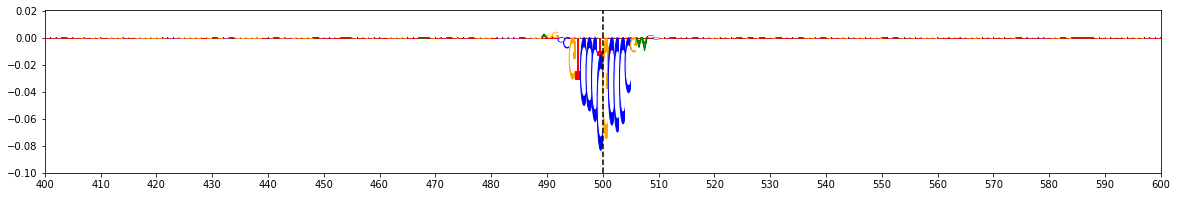



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 38

RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 11   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 5.9060E-15   ||    Coloc: False   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 2.4283   ||   Center / 200bp : 0.7089

Effect Motif: TGCTGCCATCTGCTGGGAAAT


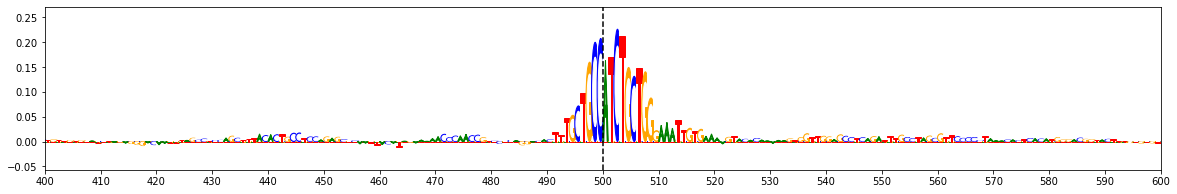

Noneffect Allele: T   ||   Noneffect Center: 0.825   ||   Center / 200bp : 0.4577

Noneffect Motif: TGCTGCTATCTGCTGGGAAAT


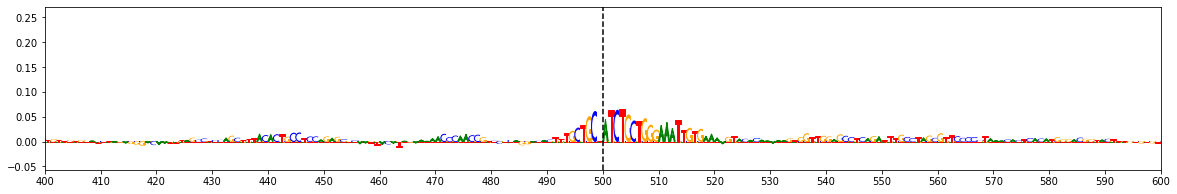

gkmExplain Score: 0.2512  ||  ISM Score: 2.5248  ||  deltaSVM Score: 14.5344

gkmExplain P-Value: 0.025476  ||  ISM P-Value: 0.000945  ||  deltaSVM P-Value: 0.000946

Difference Motif: TGCTGC(C/T)ATCTGCTGGGAAAT


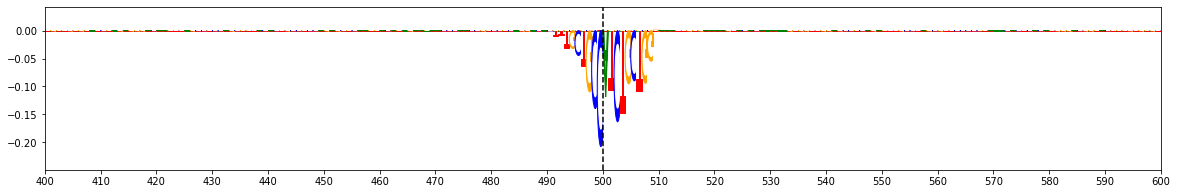



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 415

RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 93   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.7306E-03   ||    Coloc: False   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.3531   ||   Center / 200bp : 0.262

Effect Motif: GGGCGGAG


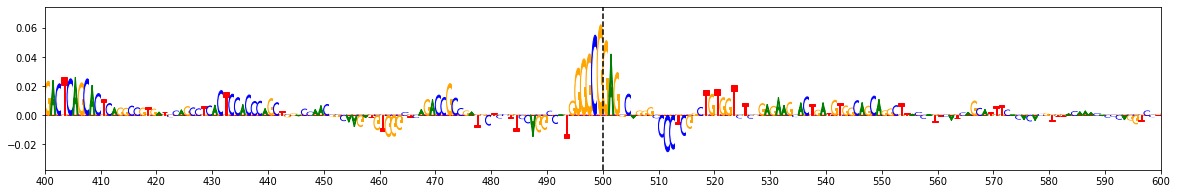

Noneffect Allele: A   ||   Noneffect Center: -0.0313   ||   Center / 200bp : 0.0154

Noneffect Motif: GGGCAGAG


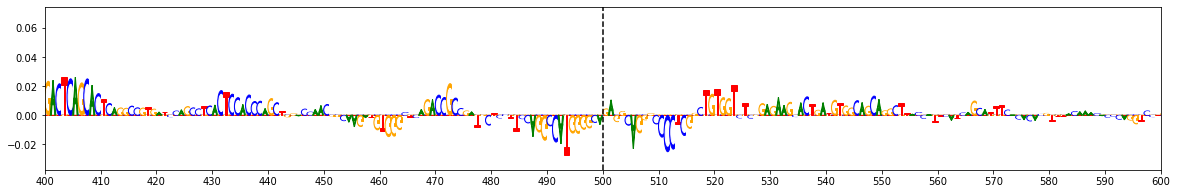

gkmExplain Score: 0.2467  ||  ISM Score: 0.8391  ||  deltaSVM Score: 4.8426

gkmExplain P-Value: 0.026564  ||  ISM P-Value: 0.036553  ||  deltaSVM P-Value: 0.037269

Difference Motif: GGGC(G/A)GAG


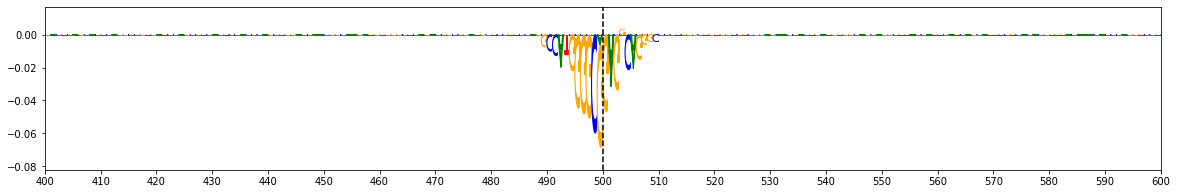



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 390

RSID: rs7599054   ||    chr2 : 134782975 - 134782976   ||    Locus: 78   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.5796E-06   ||    Coloc: False   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 2.6442   ||   Center / 200bp : 0.6477

Effect Motif: CCACTAGGGGGCA


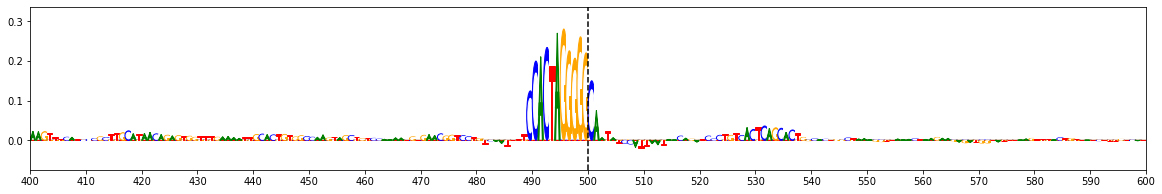

Noneffect Allele: A   ||   Noneffect Center: 0.9784   ||   Center / 200bp : 0.4131

Noneffect Motif: CCACTAGGGGACA


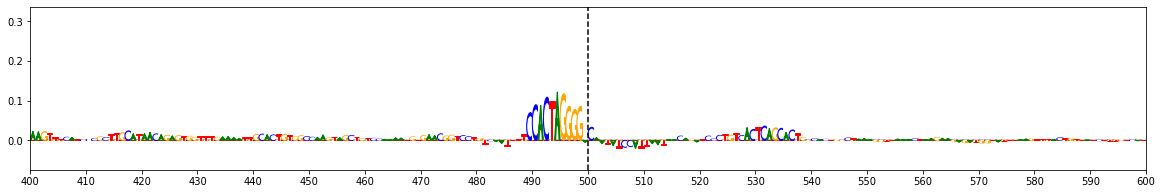

gkmExplain Score: 0.2346  ||  ISM Score: 2.7607  ||  deltaSVM Score: 16.2114

gkmExplain P-Value: 0.029762  ||  ISM P-Value: 0.000686  ||  deltaSVM P-Value: 0.000637

Difference Motif: CCACTAGGGG(G/A)CA


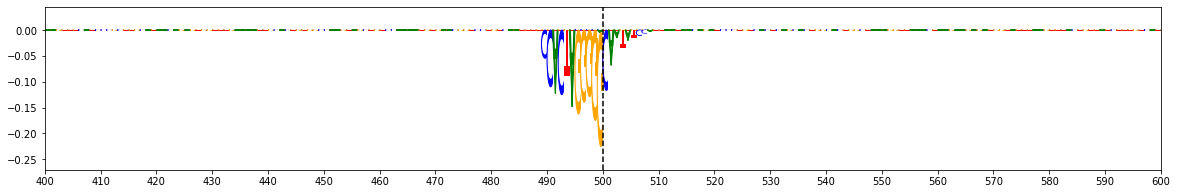



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 205

RSID: rs2526377   ||    chr17 : 58332679 - 58332680   ||    Locus: 57   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1269E-07   ||    Coloc: True   ||    Confidence: 1


Effect Allele: A   ||   Effect Center: 1.0607   ||   Center / 200bp : 0.4072

Effect Motif: ACAGGAAACAGAAGGG


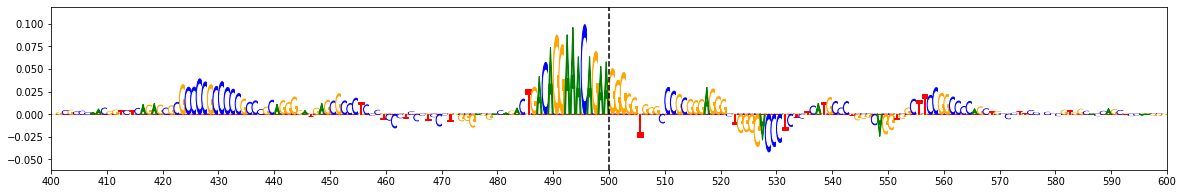

Noneffect Allele: G   ||   Noneffect Center: 0.5684   ||   Center / 200bp : 0.2805

Noneffect Motif: ACAGGAAACAGAGGGG


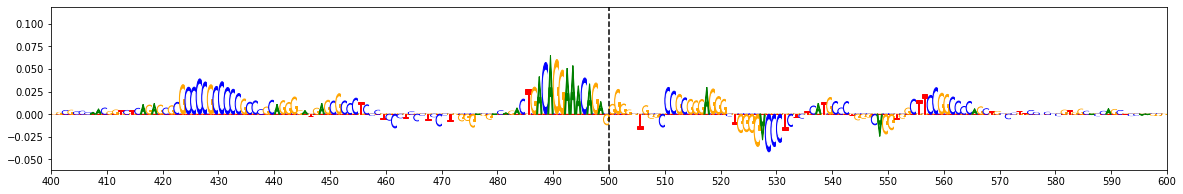

gkmExplain Score: 0.1267  ||  ISM Score: 0.9148  ||  deltaSVM Score: 5.3633

gkmExplain P-Value: 0.108778  ||  ISM P-Value: 0.028383  ||  deltaSVM P-Value: 0.027582

Difference Motif: ACAGGAAACAGA(A/G)GGG


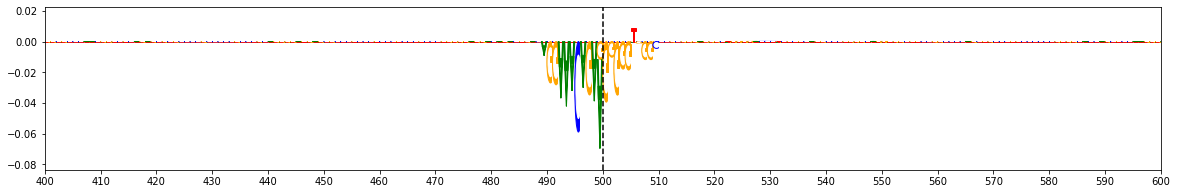



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 2

RSID: rs6684490   ||    chr1 : 39890482 - 39890483   ||    Locus: 31   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.5400E-05   ||    Coloc: True   ||    Confidence: 1


Effect Allele: A   ||   Effect Center: 2.5095   ||   Center / 200bp : 0.6208

Effect Motif: ACTTCCCTATTTCAAAGAGGATGT


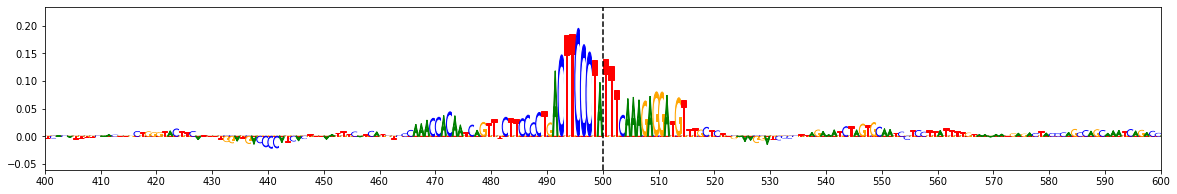

Noneffect Allele: G   ||   Noneffect Center: 1.959   ||   Center / 200bp : 0.5629

Noneffect Motif: ACTTCCCTGTTTCAAAGAGGATGT


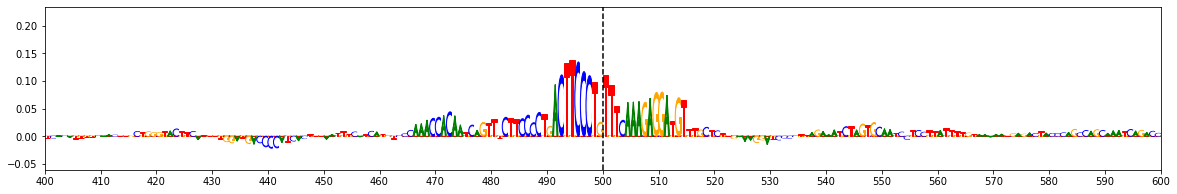

gkmExplain Score: 0.0579  ||  ISM Score: 0.8816  ||  deltaSVM Score: 5.1532

gkmExplain P-Value: 0.357647  ||  ISM P-Value: 0.031665  ||  deltaSVM P-Value: 0.031074

Difference Motif: ACTTCCCT(A/G)TTTCAAAGAGGATGT


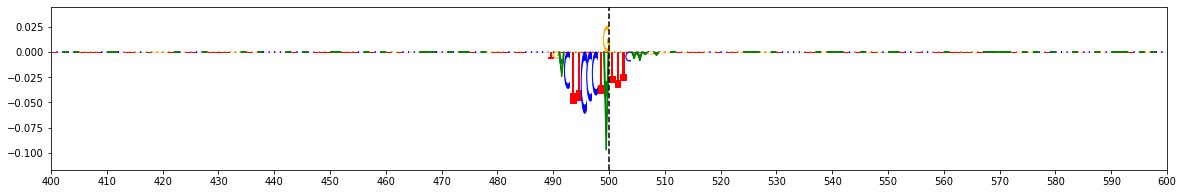



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 509

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.054   ||   Center / 200bp : 0.0343

Effect Motif: CCCCTGCCGC


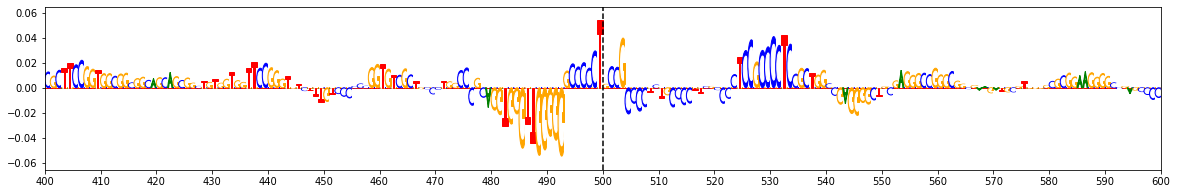

Noneffect Allele: C   ||   Noneffect Center: -0.0491   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCCGCCGC


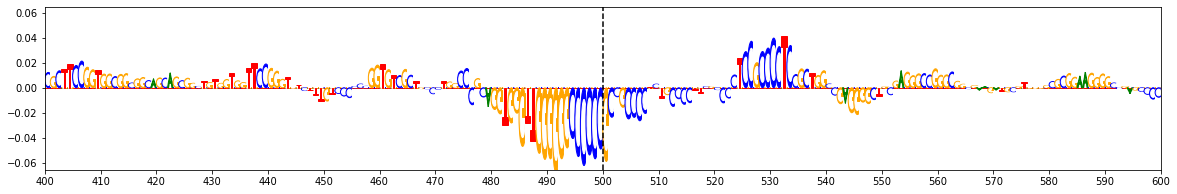

gkmExplain Score: 0.0343  ||  ISM Score: 1.2406  ||  deltaSVM Score: 7.9585

gkmExplain P-Value: 0.56191  ||  ISM P-Value: 0.010945  ||  deltaSVM P-Value: 0.007808

Difference Motif: CCCC(T/C)GCCGC


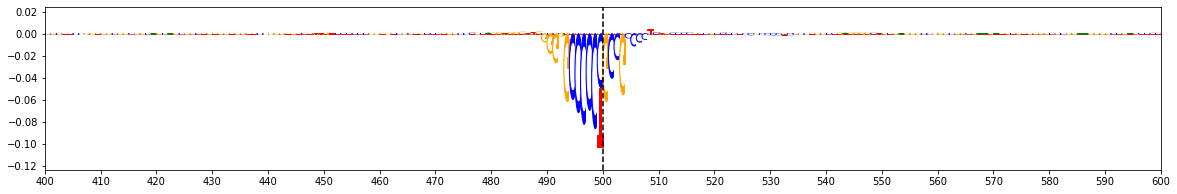



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 306

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


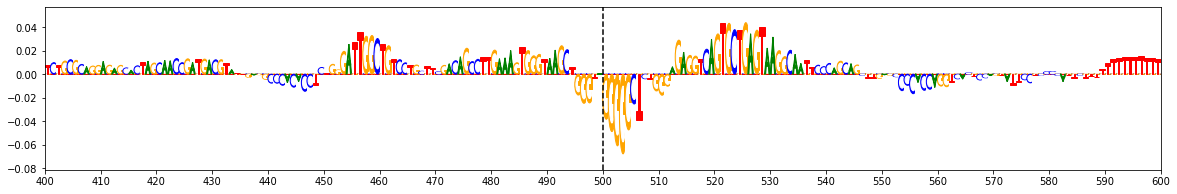

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


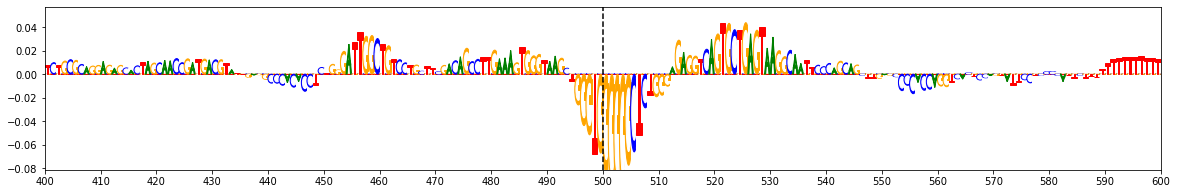

gkmExplain Score: 0.0  ||  ISM Score: 0.8848  ||  deltaSVM Score: 5.1086

gkmExplain P-Value: 0.999996  ||  ISM P-Value: 0.031327  ||  deltaSVM P-Value: 0.031883

Difference Motif: GGGT(A/G)GGGGG


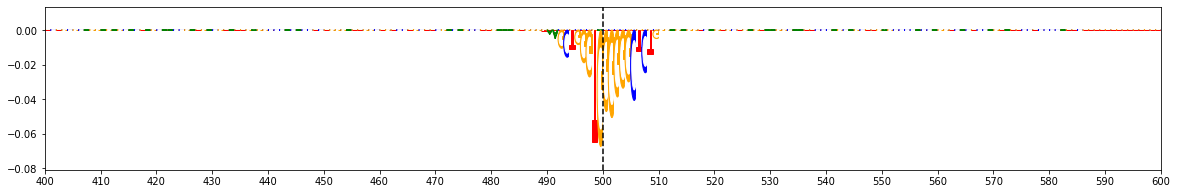



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.058548927307128906
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04825139045715332
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plot

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.07341694831848145
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. 

INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
I

INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:

INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.05738520622253418
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [clus

INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:

INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INF

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.058417320251464844
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
503,chr8,16837908,16837909,rs1717289,T,C,-,124,Chang_23andMe_Parkinsons,2.216050e-04,False,False,0.001740,0.001774,0.004829,2,TTTCAGTTCCT,TTTCAG(T/C)TCCT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
511,chr8,27369272,27369273,rs755951,A,C,-,126,Alzheimers_Jansen_2018,1.307576e-11,True,True,0.012861,0.013238,0.005548,2,TGGCCTGTAGGGGG,TGGC(C/A)TGTAGGGGG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
237,chr19,18438073,18438074,rs2303696,C,T,+,69,Alzheimers_Kunkle_2019,1.893000e-05,True,True,0.018418,0.019960,0.018014,2,GTCCCCGCCCCGAA,GTCCC(C/T)GCCCCGAA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
38,chr11,60251676,60251677,rs636317,C,T,-,11,Alzheimers_Kunkle_2019,5.906000e-15,False,True,0.000945,0.000946,0.025476,2,TGCTGCCATCTGCTGGGAAAT,TGCTGC(C/T)ATCTGCTGGGAAAT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
358,chr2,127128581,127128582,rs13025717,T,C,+,77,Alzheimers_Jansen_2018,9.125833e-17,False,True,0.017362,0.018746,0.025503,2,GCCCCGCCCAAT,GCCC(C/T)GCCCAAT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
415,chr3,52498433,52498434,rs181391313,G,A,-,93,Chang_23andMe_Parkinsons,2.730650e-03,False,True,0.036553,0.037269,0.026564,2,GGGCGGAG,GGGC(G/A)GAG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
390,chr2,134782975,134782976,rs7599054,G,A,-,78,Chang_23andMe_Parkinsons,1.579610e-06,False,True,0.000686,0.000637,0.029762,2,CCACTAGGGGGCA,CCACTAGGGG(G/A)CA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
402,chr3,49007333,49007334,rs6781790,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,True,0.028788,0.029232,0.073586,1,GAGGGCGCTGT,GAGGG(C/T)GCTGT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
148,chr17,4901871,4901872,rs79436576,T,C,+,55,Alzheimers_Lambert_2013,4.789000e-05,True,True,0.012801,0.011930,0.075314,1,TGGCCCCGCCCC,TGGCC(C/T)CGCCCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
445,chr4,89829438,89829439,rs2737005,G,A,+,103,23andme_PD_hg38,1.087510e-08,True,True,0.021971,0.023027,0.086575,1,GCAACACTTCCTCT,GCAAC(A/G)CTTCCTCT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
